# Predicting formation enthalpy of solids using Sine Coulomb Matrix representation for Kernel Ridge Regression model

Here we study the accuracy and time used to predict formation enthalpies of solids using Sine Coulomb Matrix (SCM) crystal representation with Kernel Ridge Regression (KRR) model, which are used in [Faber et al (2015)](https://arxiv.org/abs/1503.07406).

Code adapted from https://github.com/hackingmaterials/matminer_examples/blob/master/scripts/kernel_ridge_SCM_OFM.py (By Kyle Bystrom)

### Import packages 

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import argparse
import time
import warnings
import matplotlib.pyplot as plt

from pymatgen.core.structure import Structure

from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import KFold, ShuffleSplit, GridSearchCV, cross_val_predict, train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.utils import shuffle

from matminer.featurizers.structure import SineCoulombMatrix
from matminer.datasets.dataframe_loader import load_flla

## Loading flla datasets

In [2]:
%%time
df = load_flla()

CPU times: user 7.01 s, sys: 143 ms, total: 7.16 s
Wall time: 7.36 s


In [3]:
df.head(1)

,material_id,e_above_hull,formula,nsites,structure,formation_energy,formation_energy_per_atom
0,mp-10,0.107405,{'As': 1.0},2,"[[1.11758409 0.79025129 1.93571242] As, [3.352...",0.21481,0.107405


In [4]:
print ("Shape of data: ", df.shape)

Shape of data:  (3938, 7)


As can be seen from the two figures below, our dataset is the same as Faber's dataset. 
<img src="occurrence.png" style="width: 600px;"/> 
Image Source (left)  : Generated using `element_occurrence.ipynb` <br>
Image Source (right) : [Faber 2015 Figure 2](https://arxiv.org/pdf/1503.07406.pdf)

## Data input

Here, we specify several different training set sizes to train Kernel Ridge Regression model. Performance of the trained model in predicting the testing set is then quantified.

In [5]:
size = [10, 100, 500, 1000, 2000, 3000]

#### Compute Sine Coulomb Matrix (SCM) representation

In [6]:
scm = SineCoulombMatrix()

In [7]:
start = time.perf_counter()
df = scm.featurize_dataframe(df, col_id='structure')
# Take the eigenvalues of the SCMs to form vector descriptors
df['sine coulomb matrix'] = pd.Series([np.sort(np.linalg.eigvals(s)) \
                                                          for s in df['sine coulomb matrix']], df.index)
finish = time.perf_counter()
print ("Time to featurize %i datasets: %f seconds" %(df.shape[0], (finish-start)))

Time to featurize 3938 datasets: 5.254359 seconds


Input X and y

In [8]:
X = df['sine coulomb matrix'].as_matrix()
Y = df['formation_energy_per_atom'].as_matrix()
nt = max(df['nsites'])

Append each vector descriptor with zeroes to make them all the same size.

In [9]:
XLIST = []
for x in X:
    XLIST.append(np.append(x, np.zeros(nt - x.shape[0])))
X = np.array(XLIST)
print (X.shape)

(3938, 25)


## Build ML model

Set up KernelRidgeRegression Model

In [10]:
krr = KernelRidge()

Cross validation with 5 splits is used

In [11]:
num_splits = 5
inner_cv = KFold(n_splits=num_splits-1, shuffle=False, random_state=0)

Performing GridSearchCV for hyperparameter searching

In [12]:
params = {}
params['scm'] = [{'kernel' : ['rbf'], 'alpha' : [10**(-a) for a in range(2,6)],
    'gamma': [1/2.0/s/s for s in (20000,40000,80000,160000,320000)]},
    {'kernel' : ['laplacian'], 'alpha' : [10**(-a) for a in range(2,6)],
    'gamma' : [1.0/s for s in (20000,40000,80000,160000,320000)]}]

In [13]:
model = GridSearchCV(krr, params['scm'], cv=inner_cv, refit=True)

Evaluate accuracy of KRR model for varying data sizes using SCM featurization and time it

In [14]:
metrics = ['mae', 'rmse', 'r2', 'time_used', 'optimum_param']
results = dict.fromkeys(size)
for k in results:
    results[k] = dict.fromkeys(metrics, 0.0)

In [15]:
results = []
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    for s in size:
        start = time.perf_counter()
        mae, rmse, r2 = 0.0, 0.0, 0.0
        shuffle = ShuffleSplit(n_splits=num_splits, train_size=s)
        for train_index, test_index in shuffle.split(X):
            x_train, x_test = X[train_index], X[test_index]
            y_train, y_test = Y[train_index], Y[test_index]
            model.fit(x_train, y_train)
            y_pred = model.predict(x_test)
            mae += mean_absolute_error(y_pred, y_test) / num_splits
            rmse += np.sqrt(mean_squared_error(y_pred, y_test)) / num_splits
            r2 += r2_score(y_test, y_pred) / num_splits
        finish = time.perf_counter()
        results.append({'size': s, 'mae': mae, 'rmse': rmse, 'r2': r2, 'time_used': finish-start, 'optimum_param': model.best_params_})

Results of accuracy and time performance with respect to training set size

In [27]:
results = pd.DataFrame(results)
results.set_index("size")

,mae,optimum_param,r2,rmse,time_used
size,,,,,
10,0.886327,"{'alpha': 0.01, 'gamma': 2.5e-05, 'kernel': 'l...",-0.222985,1.145042,1.200375
100,0.711855,"{'alpha': 1e-05, 'gamma': 1.25e-05, 'kernel': ...",0.234334,0.936100,1.530647
500,0.521381,"{'alpha': 0.01, 'gamma': 6.25e-06, 'kernel': '...",0.590995,0.691191,9.197117
1000,0.438866,"{'alpha': 0.01, 'gamma': 1.25e-05, 'kernel': '...",0.681615,0.601708,41.093267
2000,0.382148,"{'alpha': 0.01, 'gamma': 6.25e-06, 'kernel': '...",0.724225,0.540696,185.905743
3000,0.343390,"{'alpha': 0.01, 'gamma': 1.25e-05, 'kernel': '...",0.792822,0.488853,419.317211


#### Plot of time performance and accuracy of KRR model 

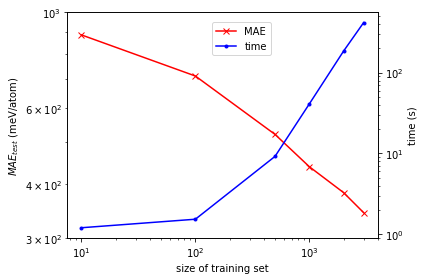

In [26]:
fig, ax1 = plt.subplots()
ax1.set_xlabel('size of training set')
ax1.set_ylabel('$MAE_{test}$ (meV/atom)')
ax1.loglog(size, results['mae']*1e3, color='r', marker='x', label='MAE')
ax1.set_ylim([3e2, 1e3])

ax2 = ax1.twinx()

ax2.set_ylabel('time (s)')
ax2.loglog(size, results['time_used'], color='b', marker='.', label='time')

fig.legend(loc=(0.5, 0.8))

fig.tight_layout()
plt.show()

*Finding*: Mean absolute error is similar to the error in Faber's paper, as shown below (red line: SCM).
<img src='fig3.png' width=300/>

## Visualization of prediction

Here, we train the KRR model using a training set of 3000 compounds (Same as in Faber's paper). The model is then used to predict a distinct testing set and a visualization of the prediction accuracy is presented.

Partition into training and testing set <br>
Training - 3000 compounds; Testing - 938 compounds

In [18]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=df.shape[0]-3000, shuffle=True)

Kernel Ridge Regression model (Using GridSearchCV to find best hyperparameter)

In [19]:
krr = KernelRidge()

In [20]:
hpsel = GridSearchCV(krr, params['scm'], cv=inner_cv, refit=True)

Train KRR model using training set data

In [21]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    hpsel.fit(x_train, y_train)

Assign best hyperparameters to model

In [22]:
model = hpsel.best_estimator_

Prediction of data

In [23]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    cv_train = cross_val_predict(model, x_train, y_train, cv=KFold(n_splits=5))
    cv_test = cross_val_predict(model, x_test, y_test, cv=KFold(n_splits=5))

Statistics of testing set prediction

In [24]:
mae_train, mae_test = mean_absolute_error(y_train, cv_train), mean_absolute_error(y_test, cv_test)
rmse_train, rmse_test = np.sqrt(mean_squared_error(y_train, cv_train)), np.sqrt(mean_squared_error(y_test, cv_test))
r2_train, r2_test = r2_score(y_train, cv_train), r2_score(y_test, cv_test)

Plot predictions

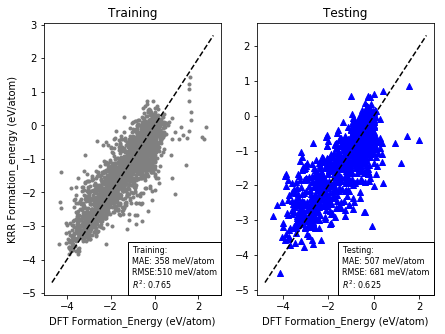

In [25]:
fig, (ax1, ax2) = plt.subplots(1, 2)

ax1.scatter(y_train, cv_train, c='grey', marker='.')
ax1.plot(ax1.get_xlim(), ax1.get_xlim(), 'k--')
ax1.text(0.495, 0.026, 'Training:\nMAE: {:.0f} meV/atom\nRMSE:{:.0f} meV/atom\n$R^2$: {:.3f}'.format(mae_train*1e3, rmse_train*1e3, r2_train),
         transform=ax1.transAxes, fontsize=8,
         bbox={'facecolor': 'w', 'edgecolor': 'k'})
ax1.set_title('Training')
ax1.set_xlabel('DFT Formation_Energy (eV/atom)')
ax1.set_ylabel('KRR Formation_energy (eV/atom)')

ax2.scatter(y_test, cv_test, c='b', marker='^')
ax2.plot(ax2.get_xlim(), ax2.get_xlim(), 'k--')
ax2.text(1.68, 0.026, 'Testing:\nMAE: {:.0f} meV/atom\nRMSE: {:.0f} meV/atom\n$R^2$: {:.3f}'.format(mae_test*1e3, rmse_test*1e3, r2_test),
         transform=ax1.transAxes, fontsize=8,
         bbox={'facecolor': 'w', 'edgecolor': 'k'})
ax2.set_title('Testing')
ax2.set_xlabel('DFT Formation_Energy (eV/atom)')

fig.set_size_inches(7, 5)

MAE of prediction here (0.51 meV/atom) is close to the MAE shown in Faber
's paper (0.37 eV/atom)